In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocesamiento de los datos

En este notebook se trabajarán los conjuntos de datos por separado, según nodos que miden temperatura y humedad a 1 metro de profundidad ("Humedad 1" y "Temperatura 1") y los que lo hacen a 1,5 metros de profundidad ("Humedad 2" y "Temperatura 2"), integrando la medición de "pH" en ambos segmentos.

### Definir ruta de los conjuntos de datos originales

In [ ]:
root_dir = "../dataset/raw"

### Generar DataFrames
Generar un DataFrame por cada tipo de medición e integrar el pH en éstos

In [3]:
dataframes = {
    "temperature1": [],
    "temperature2": [],
    "humidity1": [],
    "humidity2": [],
    "ph": []
}

# Iterar sobre los nodos y archivos
for node in os.listdir(root_dir):
    node_path = os.path.join(root_dir, node)

    if os.path.isdir(node_path):
        for file in os.listdir(node_path):
            file_path = os.path.join(node_path, file)

            if file.endswith(".csv"):
                df = pd.read_csv(file_path)
                df["Node"] = node

                for key in dataframes.keys():
                    if key in file:
                        dataframes[key].append(df)
                        break

# Combinar los DataFrames individuales en uno solo por tipo de medición
temperature1_combined = pd.concat(dataframes["temperature1"], ignore_index=True)
temperature2_combined = pd.concat(dataframes["temperature2"], ignore_index=True)
humidity1_combined = pd.concat(dataframes["humidity1"], ignore_index=True)
humidity2_combined = pd.concat(dataframes["humidity2"], ignore_index=True)
ph_combined = pd.concat(dataframes["ph"], ignore_index=True)

In [4]:
# Conversión de columnas de tiempo a tipo Datetime
for df in [temperature1_combined,
           temperature2_combined,
           humidity1_combined,
           humidity2_combined,
           ph_combined]:
    df["Timestamp"] = pd.to_datetime(df["Timestamp"])
    df["Epoch"] = pd.to_datetime(df["Epoch"],
                                 unit="ms",
                                 origin="unix")

In [5]:
# Ejemplo de registros en DataFrame
print("temperature1_combined:")
temperature1_combined.head()

temperature1_combined:


,Device,Slot,Epoch,Timestamp,Value,Node
0,A1-GeoNodo 01,Temperatura 1,2023-10-24 19:58:57,2023-10-24 16:58:57,50.7,A1
1,A1-GeoNodo 01,Temperatura 1,2023-10-24 19:59:56,2023-10-24 16:59:56,50.8,A1
2,A1-GeoNodo 01,Temperatura 1,2023-10-24 20:00:56,2023-10-24 17:00:56,50.8,A1
3,A1-GeoNodo 01,Temperatura 1,2023-10-24 20:01:56,2023-10-24 17:01:56,50.6,A1
4,A1-GeoNodo 01,Temperatura 1,2023-10-24 20:02:27,2023-10-24 17:02:27,50.5,A1


### Tipos de datos y cantidad de valores nulos por DataFrame

In [6]:
ph_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412513 entries, 0 to 412512
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Device     412513 non-null  object        
 1   Slot       412513 non-null  object        
 2   Epoch      412513 non-null  datetime64[ns]
 3   Timestamp  412513 non-null  datetime64[ns]
 4   Value      412513 non-null  float64       
 5   Node       412513 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(3)
memory usage: 18.9+ MB


Después de aplicar el método *info* a todos los DataFrames:
* Todos los tipos de datos son correctos.
* No hay valores nulos en ninguna de las columnas.

### Duplicados a nivel de filas

In [7]:
temperature1_combined.duplicated().sum()

np.int64(0)

Después de aplicar el método *duplicated*, en conjunto con el método *sum*, a todos los DataFrames, no se identificó ningún registro duplicado.

### Concatenar DataFrames de Temperatura 1 con Humedad 1, Temperatura 2 con Humedad 2

#### Definir "Epoch" y "Node" como índices de los DataFrames
Índice compuesto para realizar operaciones, como filtrado y agrupamiento, en base a las columnas de Datetime con UTC 0 y de Nodo de medición.

Además, se eliminan las columnas redundantes ("Device", "Slot", "Timestamp")

In [8]:
def preprocess_df(df, value_column, new_name):
    """
    Preprocesa un DataFrame estableciendo índices, eliminando columnas innecesarias y renombrando la columna de valores.

    Args:
        df (pd.DataFrame): El DataFrame a preprocesar.
        value_column (str): El nombre de la columna de valores a renombrar.
        new_name (str): El nuevo nombre para la columna de valores.

    Returns:
        pd.DataFrame: El DataFrame preprocesado.
    """
    return (
        df
        .set_index(["Epoch", "Node"], drop=True)
        .drop(columns=["Device", "Slot", "Timestamp"])
        .rename(columns={value_column: new_name})
    )

In [9]:
temperature1_combined = preprocess_df(temperature1_combined, "Value", "Temperature 1")
temperature2_combined = preprocess_df(temperature2_combined, "Value", "Temperature 2")
humidity1_combined = preprocess_df(humidity1_combined, "Value", "Humidity 1")
humidity2_combined = preprocess_df(humidity2_combined, "Value", "Humidity 2")
ph_combined = preprocess_df(ph_combined, "Value", "pH")

In [10]:
temperature1_combined

,,Temperature 1
Epoch,Node,
2023-10-24 19:58:57,A1,50.7
2023-10-24 19:59:56,A1,50.8
2023-10-24 20:00:56,A1,50.8
2023-10-24 20:01:56,A1,50.6
2023-10-24 20:02:27,A1,50.5
...,...,...
2024-01-18 17:01:56,D4,23.2
2024-01-18 17:02:56,D4,23.2
2024-01-18 17:03:56,D4,23.2


In [11]:
temperature_humidity_1 = (
    pd.merge(temperature1_combined, 
             humidity1_combined, 
             left_index=True, 
             right_index=True, 
             how="outer")
)
temperature_humidity_2 = (
    pd.merge(temperature2_combined, 
             humidity2_combined, 
             left_index=True, 
             right_index=True, 
             how="outer")
)

In [12]:
temperature_humidity_1.head()

,,Temperature 1,Humidity 1
Epoch,Node,,
2023-10-24 19:56:58,A3,38.3,0.0
2023-10-24 19:57:28,A3,38.3,0.0
2023-10-24 19:57:58,A3,38.3,0.0
2023-10-24 19:58:28,A3,38.5,0.0
2023-10-24 19:58:57,A1,50.7,0.0


#### Valores nulos en los DataFrames consolidados de Temperatura y Humedad
Los siguientes resultados reflejan la cantidad de valores nulos en cada una de las columnas, como efecto de combinar los DataFrames de temperatura con los de humedad.

In [13]:
print("TEMPERATURA 1 / HUMEDAD 1\n")
print(f"Cantidad de registros sin nulos: {temperature_humidity_1.dropna(how="any").shape[0]}")
print(f"Nulos por columa:\n{temperature_humidity_1.isnull().sum()}")

TEMPERATURA 1 / HUMEDAD 1

Cantidad de registros sin nulos: 411026
Nulos por columa:
Temperature 1    1236
Humidity 1        249
dtype: int64


En temperature_humidity_1:
* Hay 1236 mediciones de humedad sin mediciones de temperatura, y hay 249 de temperatura sin mediciones de humedad.
* Hay 411026 registros con ambas mediciones.

In [14]:
print("TEMPERATURA 2 / HUMEDAD 2\n")
print(f"Cantidad de registros sin nulos: {temperature_humidity_2.dropna(how="any").shape[0]}")
print(f"Nulos por columa:\n{temperature_humidity_2.isnull().sum()}")

TEMPERATURA 2 / HUMEDAD 2

Cantidad de registros sin nulos: 408590
Nulos por columa:
Temperature 2    2287
Humidity 2       1629
dtype: int64


En temperature_humidity_2:
* Hay 2287 mediciones de humedad sin mediciones de temperatura, y hay 1629 de temperatura sin mediciones de humedad.
* Hay 408590 registros con ambas mediciones.

### Separar registros de nodos con sensor de pH de los nodos sin sensor

#### Obtener valores de pH por sobre 14, para identificar nodos sin sensor de pH

In [15]:
filtered_values = ph_combined[ph_combined["pH"] > 14]
value_list = filtered_values["pH"].unique().tolist()
print(f"Valores de pH por sobre 14: {value_list}")

Valores de pH por sobre 14: [655.35]


El único valor de pH por sobre 14 es 655,35

#### Obtener lista de nodos que poseen sensor de pH

In [16]:
filtered_nodes = ph_combined[ph_combined["pH"] <= 14]
nodes_with_ph = filtered_nodes.index.get_level_values("Node").unique().tolist()
print(f"Nodos con sensor de pH: {nodes_with_ph}")

Nodos con sensor de pH: ['A1', 'B1', 'B3', 'C1', 'C3', 'D1']


#### Separar registros en DataFrames con nodos con y sin sensor de pH

In [17]:
th1 = temperature_humidity_1[~temperature_humidity_1.index.get_level_values("Node").isin(nodes_with_ph)]
th1_ph = temperature_humidity_1[temperature_humidity_1.index.get_level_values("Node").isin(nodes_with_ph)]
th2 = temperature_humidity_2[~temperature_humidity_2.index.get_level_values("Node").isin(nodes_with_ph)]
th2_ph = temperature_humidity_2[temperature_humidity_2.index.get_level_values("Node").isin(nodes_with_ph)]

print(f"Nodos en DataFrame th1: {th1.index.get_level_values("Node").unique()}\n")
print(f"Nodos en DataFrame th1_ph: {th1_ph.index.get_level_values("Node").unique()}\n")
print(f"Nodos en DataFrame th2: {th2.index.get_level_values("Node").unique()}\n")
print(f"Nodos en DataFrame th2_ph: {th2_ph.index.get_level_values("Node").unique()}\n")

Nodos en DataFrame th1: Index(['A3', 'A4', 'A2', 'D4', 'D2', 'D3', 'C2', 'C4', 'B2', 'B4'], dtype='object', name='Node')

Nodos en DataFrame th1_ph: Index(['A1', 'D1', 'C3', 'B3', 'B1', 'C1'], dtype='object', name='Node')

Nodos en DataFrame th2: Index(['A3', 'A4', 'A2', 'D4', 'D2', 'D3', 'C2', 'C4', 'B2', 'B4'], dtype='object', name='Node')

Nodos en DataFrame th2_ph: Index(['A1', 'D1', 'C3', 'B3', 'B1', 'C1'], dtype='object', name='Node')



#### Filtrar registros de ph_combined por nodos con sensor de pH

In [18]:
ph_combined = ph_combined[ph_combined.index.get_level_values("Node").isin(nodes_with_ph)]
print(f"Nodos: {ph_combined.index.get_level_values('Node').unique()}")
ph_combined

Nodos: Index(['A1', 'B1', 'B3', 'C1', 'C3', 'D1'], dtype='object', name='Node')


,,pH
Epoch,Node,
2023-10-24 19:58:57,A1,7.84
2023-10-24 19:59:56,A1,7.84
2023-10-24 20:00:56,A1,7.83
2023-10-24 20:01:56,A1,7.83
2023-10-24 20:02:27,A1,7.83
...,...,...
2023-10-28 20:33:50,D1,6.07
2023-10-28 20:34:50,D1,6.07
2023-11-16 15:20:58,D1,3.34


#### Concatenar DataFrames de Temperatura y Humedad con DataFrame de pH

In [19]:
th1_ph = (
    pd.merge(th1_ph, ph_combined, 
             left_index=True, 
             right_index=True, 
             how="outer")
)
th2_ph = (
    pd.merge(th2_ph, ph_combined, 
             left_index=True, 
             right_index=True, 
             how="outer")
)

In [20]:
th1.head()

,,Temperature 1,Humidity 1
Epoch,Node,,
2023-10-24 19:56:58,A3,38.3,0.0
2023-10-24 19:57:28,A3,38.3,0.0
2023-10-24 19:57:58,A3,38.3,0.0
2023-10-24 19:58:28,A3,38.5,0.0
2023-10-24 19:58:58,A3,38.7,0.0


In [21]:
th1_ph.head()

,,Temperature 1,Humidity 1,pH
Epoch,Node,,,
2023-10-24 19:58:57,A1,50.7,0.0,7.84
2023-10-24 19:59:56,A1,50.8,0.0,7.84
2023-10-24 20:00:56,A1,50.8,0.0,7.83
2023-10-24 20:01:56,A1,50.6,0.0,7.83
2023-10-24 20:02:27,A1,50.5,0.0,7.83


### DataFrames resultantes

#### Temperatura y Humedad 1 (sin pH)

In [22]:
print("TEMPERATURA 1 / HUMEDAD 1\n")
print(f"Cantidad de registros sin nulos: {th1.dropna(how="any").shape[0]}\n")
print(f"Nulos por columa:\n{th1.isnull().sum()}")

TEMPERATURA 1 / HUMEDAD 1

Cantidad de registros sin nulos: 309041

Nulos por columa:
Temperature 1    962
Humidity 1       156
dtype: int64


In [23]:
th1.describe()

,Temperature 1,Humidity 1
count,309197.000000,310003.000000
mean,21.929974,31.516756
std,4.862773,7.924768
min,10.400000,0.000000
25%,19.500000,27.000000
50%,21.000000,31.500000
75%,22.900000,36.300000
max,64.400000,51.300000


#### Temperatura y Humedad 2 (sin pH)

In [24]:
print("TEMPERATURA 2 / HUMEDAD 2\n")
print(f"Cantidad de registros sin nulos: {th2.dropna(how="any").shape[0]}\n")
print(f"Nulos por columa:\n{th2.isnull().sum()}")

TEMPERATURA 2 / HUMEDAD 2

Cantidad de registros sin nulos: 307270

Nulos por columa:
Temperature 2    1672
Humidity 2       1213
dtype: int64


In [25]:
th2.describe()

,Temperature 2,Humidity 2
count,308483.000000,308942.000000
mean,22.427382,27.922949
std,5.378192,7.117193
min,10.900000,0.000000
25%,19.600000,23.800000
50%,20.800000,28.900000
75%,22.700000,33.000000
max,47.800000,45.700000


#### Temperatura y Humedad 1 (con pH)

In [26]:
print("TEMPERATURA 1 / HUMEDAD 1 / PH\n")
print(f"Cantidad de registros sin nulos: {th1_ph.dropna(how="any").shape[0]}\n")
print(f"Nulos por columa:\n{th1_ph.isnull().sum()}")


TEMPERATURA 1 / HUMEDAD 1 / PH

Cantidad de registros sin nulos: 101985

Nulos por columa:
Temperature 1    275
Humidity 1        94
pH                 0
dtype: int64


In [27]:
th1_ph.describe()

,Temperature 1,Humidity 1,pH
count,102078.000000,102259.000000,102353.000000
mean,22.138890,26.762080,4.148515
std,5.757308,8.261633,1.614142
min,11.900000,0.000000,0.000000
25%,19.100000,24.400000,2.840000
50%,20.400000,27.900000,4.040000
75%,23.000000,30.300000,5.850000
max,50.800000,47.000000,7.880000


#### Temperatura y Humedad 2 (con pH)

In [28]:
print("TEMPERATURA 2 / HUMEDAD 2 / PH\n")
print(f"Cantidad de registros sin nulos: {th2_ph.dropna(how="any").shape[0]}\n")
print(f"Nulos por columa:\n{th2_ph.isnull().sum()}")

TEMPERATURA 2 / HUMEDAD 2 / PH

Cantidad de registros sin nulos: 101320

Nulos por columa:
Temperature 2    617
Humidity 2       418
pH                 0
dtype: int64


In [29]:
th2_ph.describe()

,Temperature 2,Humidity 2,pH
count,101736.000000,101935.000000,102353.000000
mean,22.941742,26.648602,4.148515
std,6.544301,7.570447,1.614142
min,13.000000,0.000000,0.000000
25%,19.200000,23.800000,2.840000
50%,20.100000,27.900000,4.040000
75%,22.900000,31.400000,5.850000
max,49.400000,37.800000,7.880000


### Observaciones
**Valores nulos**
* La cantidad de valores nulos en las columnas varía entre un DataFrame y otro.
* La columna de pH no tiene valores nulos en los conjuntos de datos donde está presente, lo cual es esperado.

**Estadísticas**
* Temperatura:
    * Las medias de temperatura para los diferentes conjuntos de datos son bastante similares (alrededro de 22°C a 22.9°C), con un rango que va desde aproximadamente 10.4 desde aproximadamente 10.4°C a 64.4°C.
    * Los datos muestran una variabilidad significativa, con valores extremos que pueden indicar la presencia de outliers.
* Humedad:
    * La media de humedad varía un poco más (27.9% a 31.5%), con un rango entre 0% y 51.3%
    * Al igual que con Temperatura, la Humedad muestra una variabilidad significativa.
* pH:
    * El rango de pH es de 0 a 7.88, con una media de aproximadamente 4.15, que parece estar dentro del rango esperado para pH en soluciones.
    * La inclusión del pH no afecta significativamente las estadísticas descriptivas de temperatura y humedad, pero proporciona una dimensión adicional de análisis.
    * Las métricas estadísticas (media, desviación estándar, cuartiles) para pH son consistentes en ambos conjuntos de datos con pH, mostrando una uniformidad en las mediciones del pH.

### Orientaciones
**Tratamiento de valores nulos**
* Para datos sin pH:
    * La mayor cantidad de registros con valores nulos en temperatura y humedad puede indicar una posible falta de cobertura o problemas con los sensores en esos periodos o nodos. Se puede considerar la imputación de estos valores nulos o la eliminación de registros con muchos nulos si no son representativos.

* Para datos con pH:
    * La calidad de los datos parece mejor en términos de cobertura cuando se incluye pH. Aun así, se deben abordar los valores nulos en temperatura y humedad. La imputación o la eliminación de registros nulos puede ser necesaria dependiendo de la proporción de datos faltantes.

## Outliers
Debido a los valores anormales de pH y Temperatura en algunos registros, específicamente en lo que se refiere a los pH=0 y a las máximas elevadas de temperatura, se realizarán algunas operaciones con las columnas correspondientes y se trazarán algunos gráficos. 

### Histograma mediciones de Temperatura, Humedad y pH

#### Regla de Sturges
Para calcular la cantidad óptima de bins para cada histograma

In [30]:
t1_clean = th1["Temperature 1"].dropna()
t2_clean = th2["Temperature 2"].dropna()
h1_clean = th1["Humidity 1"].dropna()
h2_clean = th2["Humidity 2"].dropna()

t1_ph_clean = th1_ph["Temperature 1"].dropna()
t2_ph_clean = th2_ph["Temperature 2"].dropna()
h1_ph_clean = th1_ph["Humidity 1"].dropna()
h2_ph_clean = th2_ph["Humidity 2"].dropna()

ph1_clean = th1_ph["pH"].dropna()
ph2_clean = th2_ph["pH"].dropna()

In [31]:
t1_bins = int(np.ceil(np.log2(len(t1_clean)) + 1))
t2_bins = int(np.ceil(np.log2(len(t2_clean)) + 1))
h1_bins = int(np.ceil(np.log2(len(h1_clean)) + 1))
h2_bins = int(np.ceil(np.log2(len(h2_clean)) + 1))

t1_ph_bins = int(np.ceil(np.log2(len(t1_ph_clean)) + 1))
t2_ph_bins = int(np.ceil(np.log2(len(t2_ph_clean)) + 1))
h1_ph_bins = int(np.ceil(np.log2(len(h1_ph_clean)) + 1))
h2_ph_bins = int(np.ceil(np.log2(len(h2_ph_clean)) + 1))

ph1_bins = int(np.ceil(np.log2(len(ph1_clean)) + 1))
ph2_bins = int(np.ceil(np.log2(len(ph2_clean)) + 1))

In [32]:
print(f"N° bins Temperatura 1: {t1_bins}")
print(f"N° bins Temperatura 2: {t2_bins}")
print(f"N° bins Humedad 1: {h1_bins}")
print(f"N° bins Humedad 2: {h2_bins}\n")

print(f"N° bins Temperatura 1 (c/ph): {t1_ph_bins}")
print(f"N° bins Temperatura 2 (c/ph): {t2_ph_bins}")
print(f"N° bins Humedad 1(c/ph): {h1_ph_bins}")
print(f"N° bins Humedad 2 (c/ph): {h2_ph_bins}\n")

print(f"N° bins pH 1: {ph1_bins}")
print(f"N° bins pH 2: {ph2_bins}")

N° bins Temperatura 1: 20
N° bins Temperatura 2: 20
N° bins Humedad 1: 20
N° bins Humedad 2: 20

N° bins Temperatura 1 (c/ph): 18
N° bins Temperatura 2 (c/ph): 18
N° bins Humedad 1(c/ph): 18
N° bins Humedad 2 (c/ph): 18

N° bins pH 1: 18
N° bins pH 2: 18


In [33]:
data_titles = [
    (t1_clean, "Distribución de registros de Temperatura 1 (th1)", t1_bins),
    (h1_clean, "Distribución de registros de Humedad 1 (th1)", h1_bins),
    (t2_clean, "Distribución de registros de Temperatura 2 (th2)", t2_bins),
    (h2_clean, "Distribución de registros de Humedad 2 (th2)", h2_bins),
    (t1_ph_clean, "Distribución de registros de Temperatura 1 (th1_ph)", t1_ph_bins),
    (h1_ph_clean, "Distribución de registros de Humedad 1 (th1_ph)", h1_ph_bins),
    (t2_ph_clean, "Distribución de registros de Temperatura 2 (th2_ph)", t2_ph_bins),
    (h2_ph_clean, "Distribución de registros de Humedad 2 (th2_ph)", h2_ph_bins),
    (ph1_clean, "Distribución de registros de pH 1 (th1_ph)", ph1_bins),
    (ph2_clean, "Distribución de registros de pH 2 (th2_ph)", ph2_bins)
]

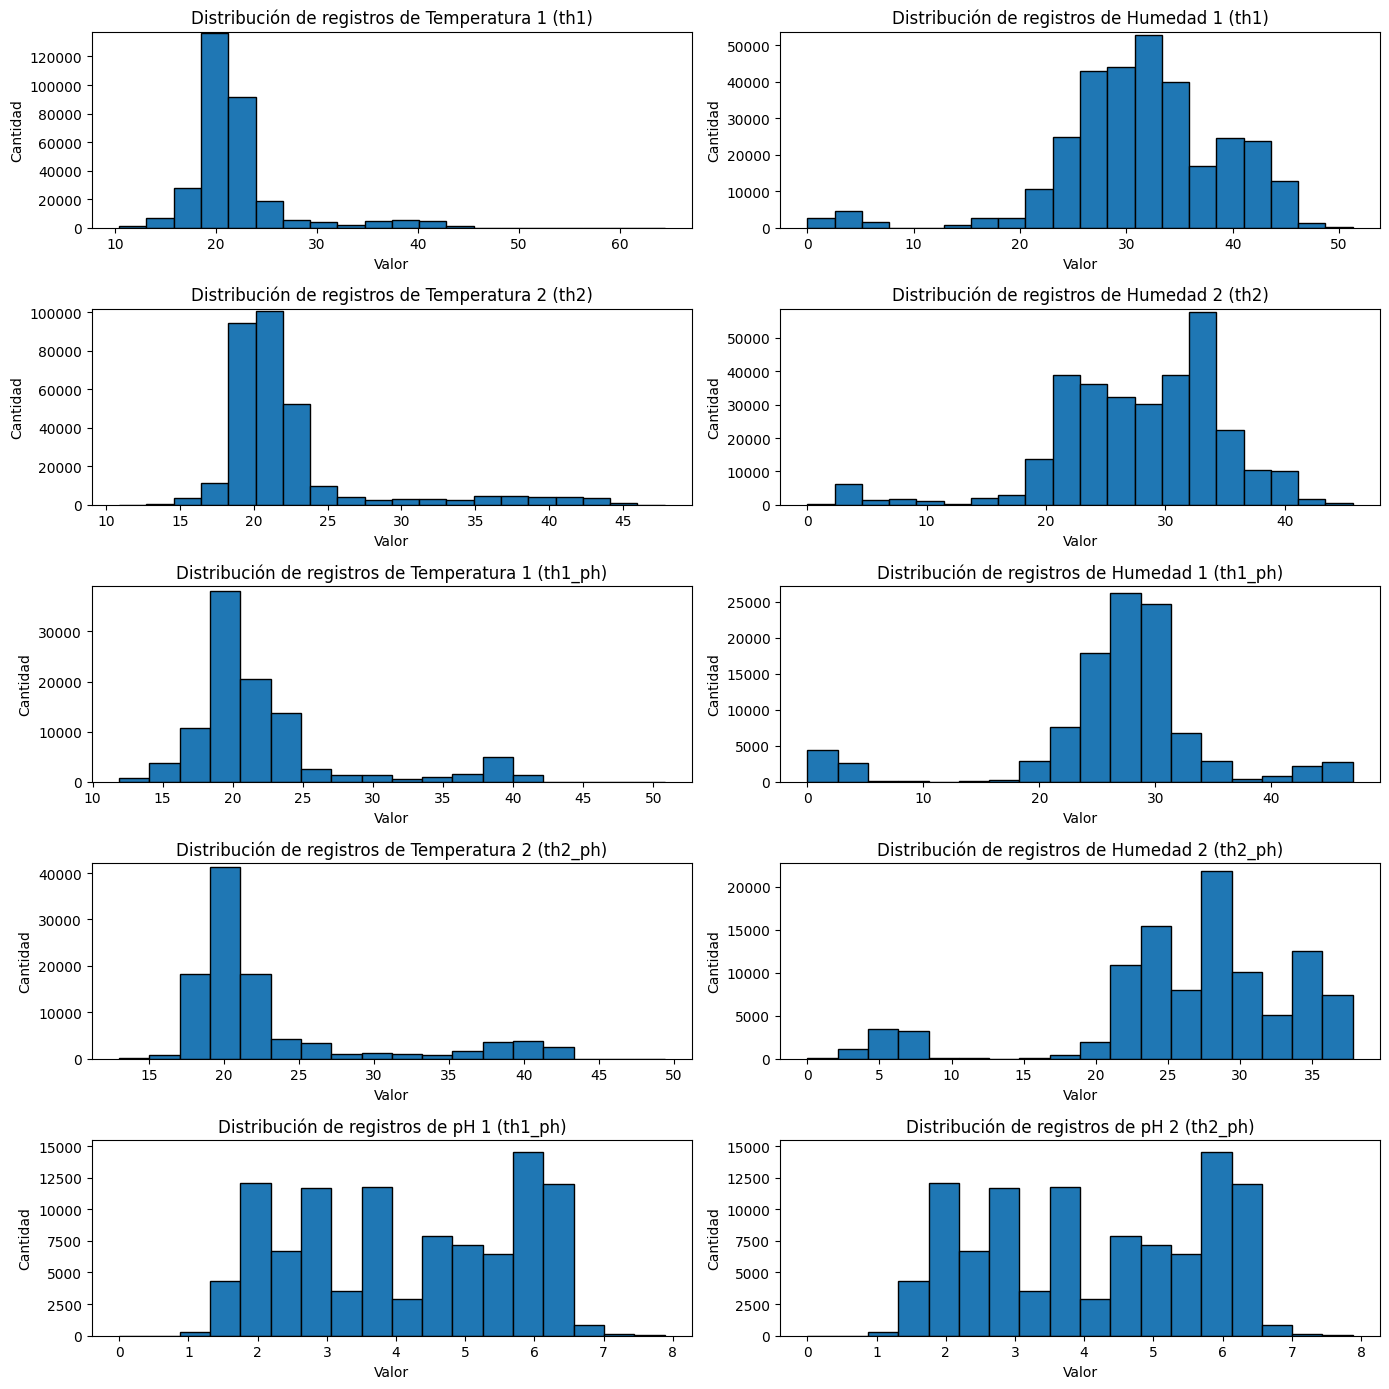

In [34]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14, 14))

for ax, (data, title, bins) in zip(axes.flatten(), data_titles):
    y_max_count = np.max(np.histogram(data, bins=bins)[0])
    ax.set_title(title)
    ax.set_xlabel("Valor")
    ax.set_ylabel("Cantidad")
    ax.hist(data, bins=bins, edgecolor="black")
    ax.set_ylim(0, y_max_count + 1000)

plt.tight_layout()
plt.show()

| **Distribución de Registros** | **Rango de Bins** | **Pico Principal** | **Conteo Máximo** | **Observaciones** |
|-------------------------------|-------------------|-------------------|-------------------|-------------------|
| **Temperatura 1 (th1)**        | De 10.4 a 64.4    | De 18.5 a 21.2    | 136273           | La mayor parte de los datos se concentra en bins con valores intermedios, con una disminución significativa hacia los valores extremos. |
| **Humedad 1 (th1)**            | De 0.0 a 51.3     | De 26.65 a 28.22    | 44187            | Hay una alta concentración de registros en el rango de bins de 20.52 a 30.78, con un notable descenso en los extremos. |
| **Temperatura 2 (th2)**        | De 10.9 a 47.8    | De 20.13 a 21.97    | 94442            | Similar a th1, la distribución está centrada en un rango intermedio, con una caída hacia los valores más altos y más bajos. |
| **Humedad 2 (th2)**            | De 0.0 a 45.7     | De 30.78 a 33.35    | 57740            | La mayoría de los registros están en los bins centrales, con una notable disminución hacia los extremos. |
| **Temperatura 1 (th1_ph)**     | De 11.9 a 50.8    | De 18.38 a 20.54    | 38097            | Hay una concentración significativa en los bins intermedios, con un descenso notable en los extremos. |
| **Humedad 1 (th1_ph)**         | De 0.0 a 47.0     | De 20.9 a 23.5    | 26179            | La mayoría de los datos están en bins intermedios, con menos frecuencia en los extremos. |
| **Temperatura 2 (th2_ph)**     | De 13.0 a 49.4    | De 19.07 a 21.09    | 41192            | Los datos están bastante distribuidos con picos en ciertos bins intermedios. |
| **Humedad 2 (th2_ph)**         | De 0.0 a 37.8     | De 25.2 a 27.3    | 21798            | Similar a los otros histogramas de humedad, hay una alta concentración en bins intermedios. |
| **pH 1 (th1_ph)**         | De 0.0 a 7.88     | De 5.69 a 6.13    | 14488            | La mayor parte de los valores de pH en esta muestra se concentra alrededor de 5.69-6.13 y 2.63-3.06, lo que podría representar dos tipos de condiciones de pH prevalentes en las muestras. |
| **pH 2 (th2_ph)**         | De 0.0 a 7.88     | De 5.69 a 6.13    | 14488            | La consistencia entre las distribuciones de pH 1 y pH 2 refuerza la fiabilidad de los datos, indicando dos principales agrupaciones de valores de pH en las muestras analizadas. |


### Boxplots

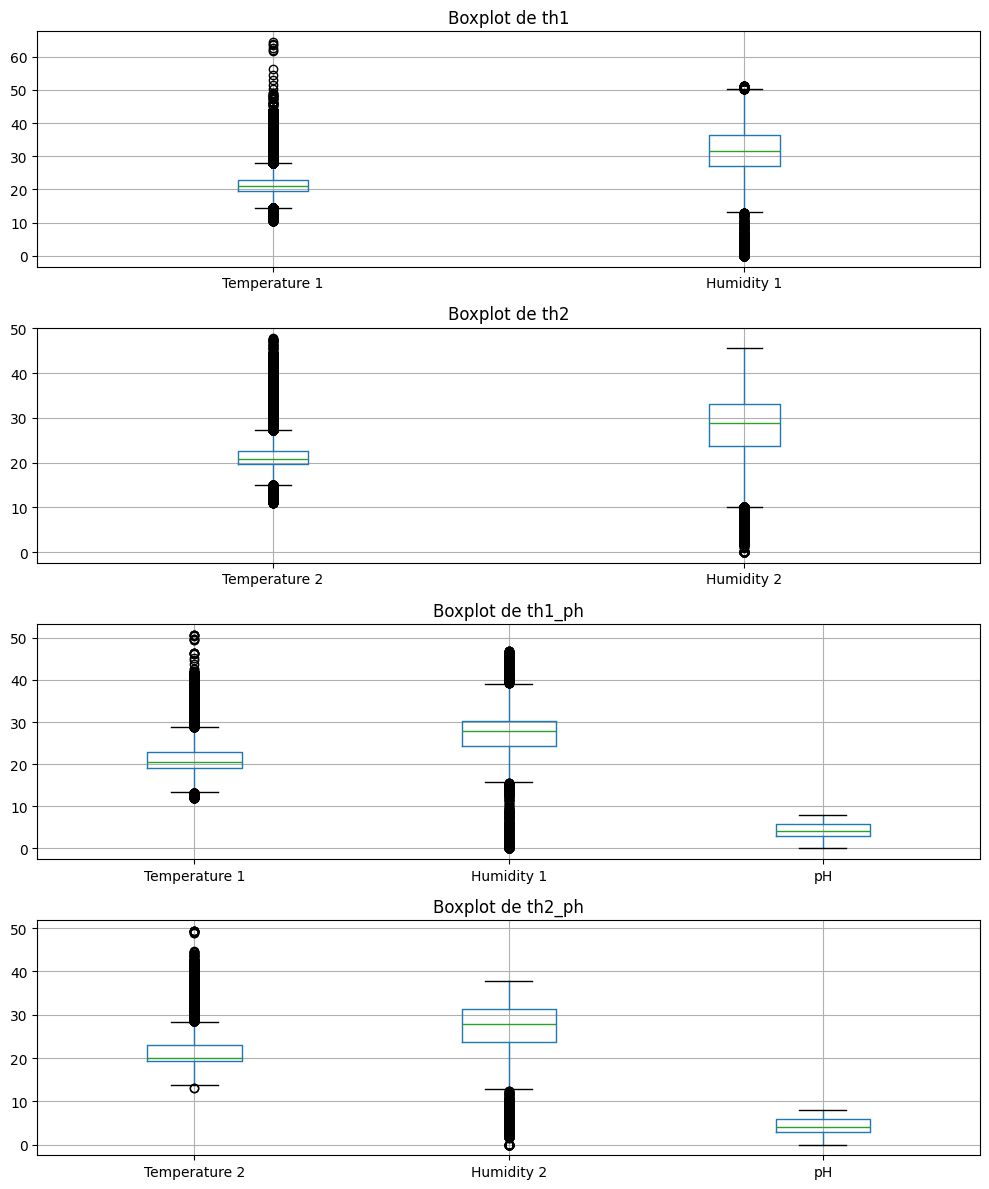

In [35]:
boxplots = [(th1, "Boxplot de th1"), 
            (th2, "Boxplot de th2"), 
            (th1_ph, "Boxplot de th1_ph"), 
            (th2_ph, "Boxplot de th2_ph")]

fig, axes = plt.subplots(nrows=len(boxplots), ncols=1, figsize=(10, 12))

for ax, (df, title) in zip(axes, boxplots):
    df.boxplot(ax=ax)
    ax.set_title(title)

plt.tight_layout()
plt.show()

### Gráficos de dispersión

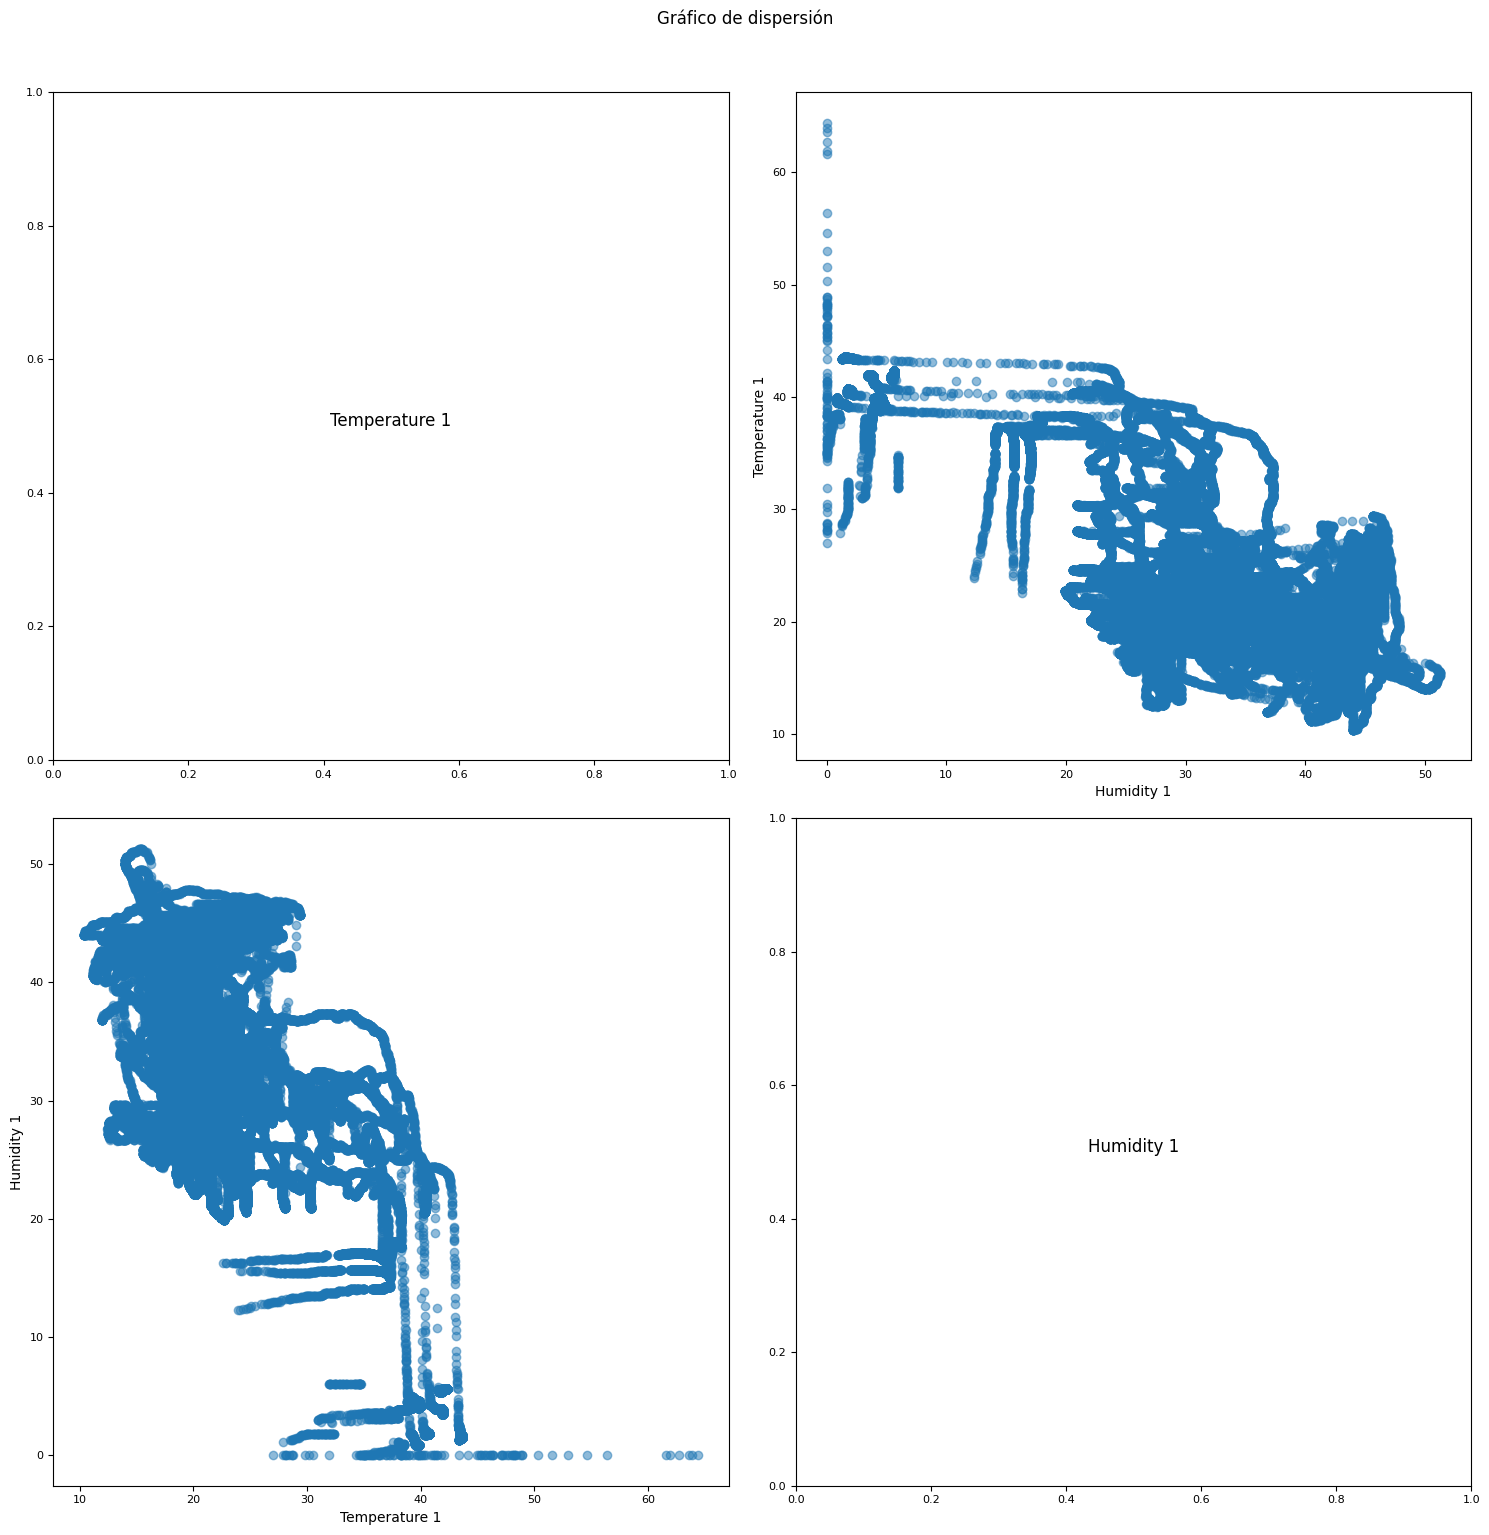

In [36]:
df = th1
columns = th1.columns
num_columns = len(columns)

fig, axes = plt.subplots(num_columns, num_columns, figsize=(15, 15))
fig.suptitle(f"Gráfico de dispersión", y=1.02)

for row in range(num_columns):
    for col in range(num_columns):
        if row != col:
            axes[row, col].scatter(df[columns[col]], df[columns[row]], alpha=0.5)
            axes[row, col].set_xlabel(columns[col])
            axes[row, col].set_ylabel(columns[row])
            
        else:
            axes[row, col].text(0.5, 0.5, columns[row], fontsize=12, ha="center")
        axes[row, col].tick_params(axis="both", which="major", labelsize=8)
        
plt.tight_layout()
plt.show()

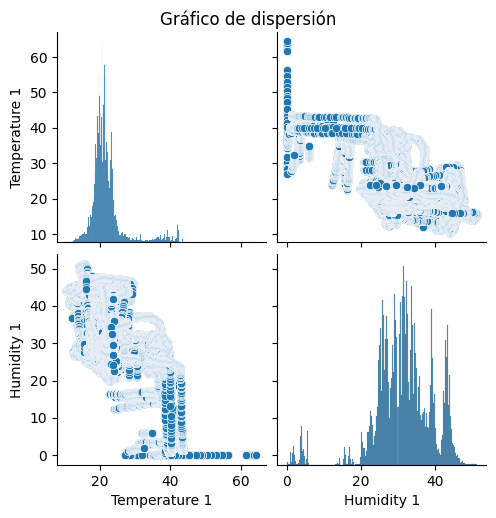

In [37]:
sns.pairplot(th1)
plt.suptitle(f"Gráfico de dispersión", y=1.02)
plt.show()